In [ ]:
# Imports
import haiku as hk
import jax
import jax.numpy as jnp
from nucleotide_transformer.pretrained import get_pretrained_model
import torch
import numpy as np
import pickle

# Load data & final params

In [47]:
# Load data
import pandas as pd

df_train = pd.read_csv('../data/promoter_200bp_train.csv')
df_test = pd.read_csv('../data/promoter_200bp_test.csv')

In [ ]:
X_train = df_train['sequence'].tolist()
Y_train = df_train['label'].values

X_test = df_test['sequence'].tolist()
Y_test = df_test['label'].values

In [ ]:
# Train and test embeddings
with open('/gpfs/scratch1/shared/awernersson/nucleotide_results_test33/200_bp_train_embeddings.pkl', 'rb') as f:
    train_embeddings = pickle.load(f)

with open('/gpfs/scratch1/shared/awernersson/nucleotide_results_test33/200_bp_test_embeddings.pkl', 'rb') as f:
    test_embeddings = pickle.load(f)

#Classifier params
with open('/gpfs/scratch1/shared/awernersson/nucleotide_results_test33/200_bp_classifier_params.pkl', 'rb') as f:
    final_params = pickle.load(f)

# Loss values
with open('/gpfs/scratch1/shared/awernersson/nucleotide_results_test33/200_bp_losses.pkl', 'rb') as f:
    loss_dict = pickle.load(f)

# Outs for attention maps
with open('/gpfs/scratch1/shared/awernersson/nucleotide_results/outs_200bp_1000_testing33.pkl', 'rb') as f:
     outs = pickle.load(f)

# Evaluation plots

In [ ]:
from Classifier import PromoterClassifier, PromoterClassifierNet
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rng = jax.random.PRNGKey(0)
model = hk.transform(PromoterClassifierNet)

# Get predictions from the classifier using embeddings
train_logits = model.apply(final_params, rng, train_embeddings, is_training=False)
test_logits = model.apply(final_params, rng, test_embeddings, is_training=False)

# Convert logits to predictions
# For binary classification with shape [batch, 1]:
train_preds = (jax.nn.sigmoid(train_logits) > 0.5).astype(int).squeeze()
test_preds = (jax.nn.sigmoid(test_logits) > 0.5).astype(int).squeeze()

print(f"Train preds shape: {train_preds.shape}")
print(f"Test preds shape: {test_preds.shape}")

# Calculate metrics
print("Train Accuracy : {:.3f}".format(accuracy_score(Y_train, train_preds)))
print("Test Accuracy : {:.3f}".format(accuracy_score(Y_test, test_preds)))

print("\nTest Classification Report:")
print(classification_report(Y_test, test_preds, target_names=['Non-Promoter', 'Promoter']))

print("\nConfusion Matrix:")
print(confusion_matrix(Y_test, test_preds))

Train preds shape: (700,)
Test preds shape: (150,)
Train Accuracy : 0.917
Test Accuracy : 0.853

Test Classification Report:
              precision    recall  f1-score   support

Non-Promoter       0.78      0.92      0.85        65
    Promoter       0.93      0.80      0.86        85

    accuracy                           0.85       150
   macro avg       0.86      0.86      0.85       150
weighted avg       0.87      0.85      0.85       150


Confusion Matrix:
[[60  5]
 [17 68]]


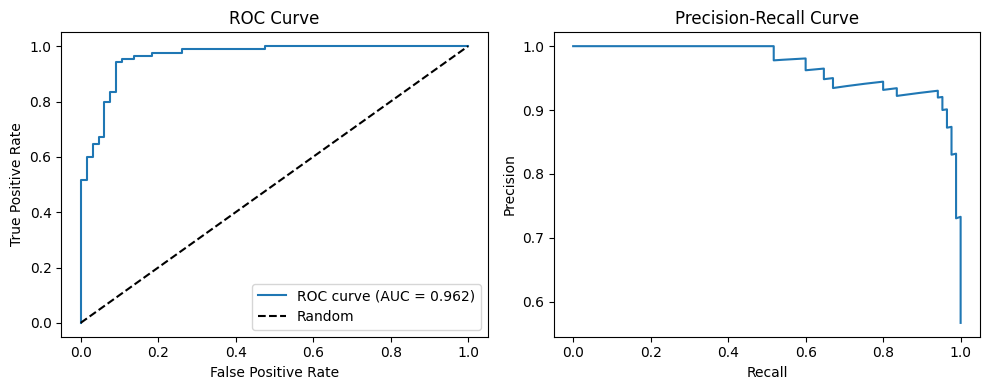

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ROC Curve
fpr, tpr, _ = roc_curve(Y_test, jax.nn.sigmoid(test_logits).squeeze())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(Y_test, jax.nn.sigmoid(test_logits).squeeze())
plt.subplot(1, 2, 2)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.tight_layout()
plt.show()

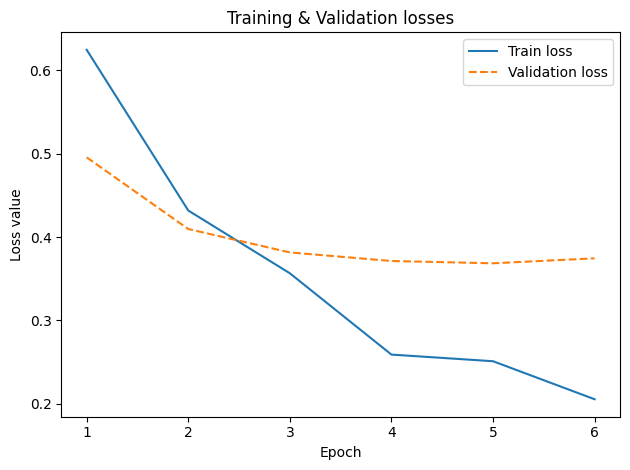

In [59]:
# Show loss curves

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Load train and val losses per epoch
train_loss = loss_dict['train_losses']
val_loss = loss_dict['val_losses']
epochs = [1,2,3,4,5,6]

plt.plot(epochs, train_loss, label = 'Train loss')
plt.plot(epochs, val_loss, linestyle='--', label= 'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.title('Training & Validation losses')
plt.tight_layout()
plt.legend()
plt.show()


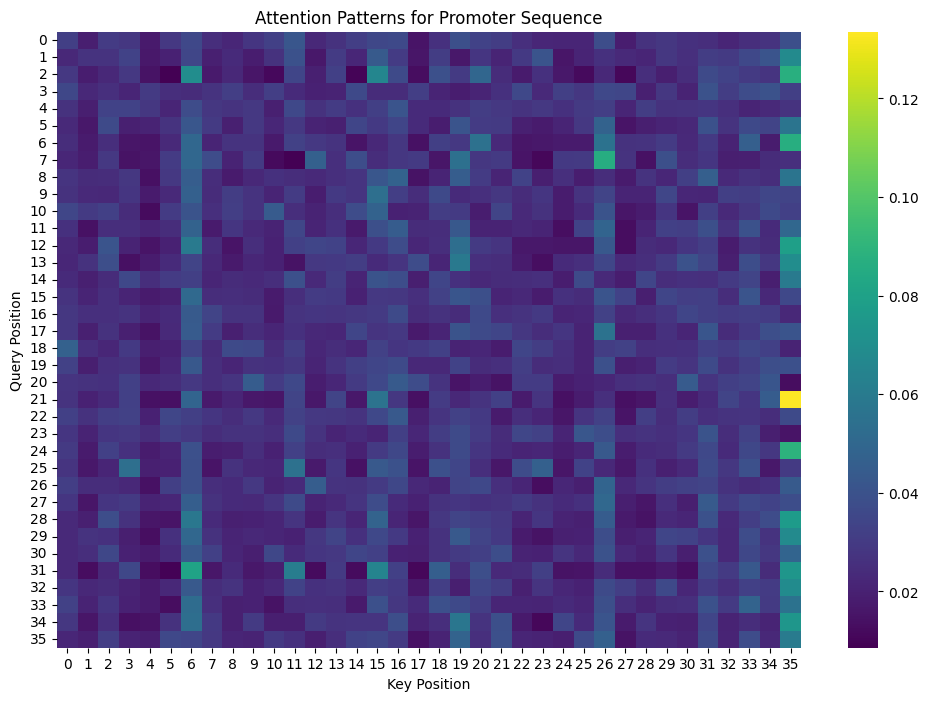

In [ ]:
# Get attention for a promoter sequence
import seaborn as sns

seq_id = 0  
attention = outs["attention_map_layer_1_number_4"][seq_id]  # Layer 1, head 4

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(attention[:36, :36], cmap='viridis', cbar=True)
plt.title('Attention Patterns for Promoter Sequence')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.show()